In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import pandas as pd
pd.__version__  # for the record

'0.24.2'

---
<a name="addplot"></a>
# Adding plots to the basic mplfinance plot()

Sometimes you may want to plot additional data within the same figure as the basic OHLC or Candlestick plot.  For example, you may want to add the results of a technical study, or some additional market data.  

This is done by passing necessary information into the call to `mplfinance.plot()` using the `addplot` ("additional plot") keyword.

The `addplot` keyword expects a `dict`.  The dict must contain the key `'data':` whose value is the actual additional data to be plotted.  This additional data may be a `list`, `numpy.ndarray`, `pandas.Series`, or `pandas.DataFrame`.  If it is a DataFrame, then *all* columns in that dataframe will be plotted.  

The rest of the `addplot` dict contains various keywords and their values that are used to configure the additional plot in relation to the basic OHLCV plot, as can be seen in the examples below.

It is *strongly* recommended that the caller construct the `addplot` dict using the helper function `mplfinance.make_addplot()` (see examples below).  This helper function:
- simplifies the syntax for specifying additional plots
- ensures that the dict contains default values for all possible configurable keywords
- does some basic checking on the keyword values to ensure they are of the correct types.

The `addplot` keyword can also accept a `list` of `dict`s, as one possible way of plotting multiple additional data sets on top of the basic OHLCV data.  See specific details in the the examples below.

---

## `addplot` examples:

Let's start with an example data set that includes Bollinger Band data, in addition to the basic OHLCV data:

In [3]:
df = pd.read_csv('data/SPY_20110701_20120630_Bollinger.csv',index_col=0,parse_dates=True)
#df = df.loc['2012-01-01':,:]
df.shape
df.head(3)
df.tail(3)

(252, 9)

,Open,High,Low,Close,Adj Close,Volume,UpperB,LowerB,PercentB
Date,,,,,,,,,
2011-07-01,132.089996,134.100006,131.779999,133.919998,117.161659,202385700,132.373927,125.316073,1.219057
2011-07-05,133.779999,134.080002,133.389999,133.809998,117.065437,165936000,133.254297,124.912703,1.066618
2011-07-06,133.490005,134.139999,133.110001,133.970001,117.205429,143331600,134.040915,124.627085,0.992467


,Open,High,Low,Close,Adj Close,Volume,UpperB,LowerB,PercentB
Date,,,,,,,,,
2012-06-27,132.419998,133.429993,131.970001,133.169998,118.980804,108088000,136.447962,128.140042,0.605441
2012-06-28,132.289993,132.990005,131.279999,132.789993,118.641281,169242100,136.500761,128.219241,0.551922
2012-06-29,135.199997,136.270004,134.850006,136.100006,121.598610,212250900,136.721010,128.792993,0.921670


---

#### Using this dataframe, we can of course plot a basic ohlc or candlestick plot:



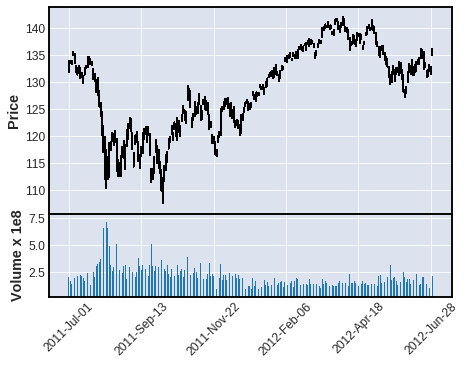

In [4]:
import mplfinance as mpf

mpf.plot(df,volume=True)

---

Let's say we want to plot the Lower Bollinger band along with the basic OHLCV plot.  

We use `make_addplot()` to create the addplot dict, and pass that into the plot() function:

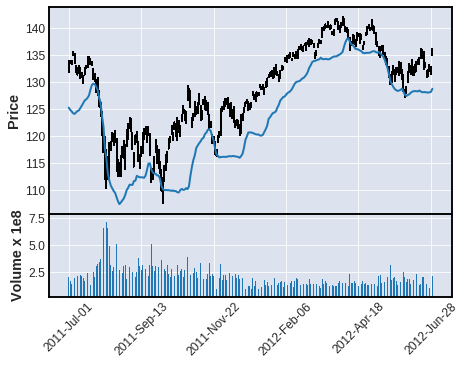

In [5]:
apdict = mpf.make_addplot(df['LowerB'])

mpf.plot(df,volume=True,addplot=apdict)

---

When creating the `addplot` dict, we can specify that we want a scatter plot:

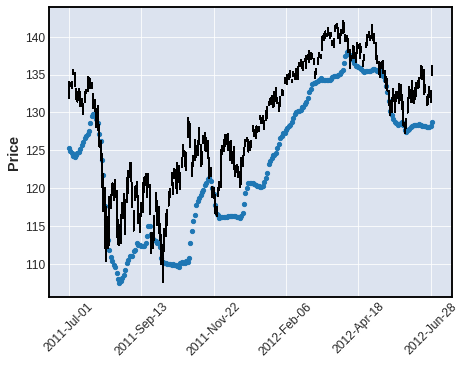

In [6]:
apd = mpf.make_addplot(df['LowerB'],scatter=True)

mpf.plot(df,addplot=apd)

---

The above example is a trivial use of a scatter plot, where the default line plot makes more sense.  

A more helpful use of a scatter plot might be to highlight specific movements in the data.  For example, let's say we want to highlight whenever the "Percent B" Bollinger metric drops below zero.  To do this, let's first calculate a series that contains this information:

In [7]:
def percentB_belowzero(percentB,price):
    import numpy as np
    signal   = []
    previous = -1.0
    for date,value in percentB.iteritems():
        if value < 0 and previous >= 0:
            signal.append(price[date]*0.99)
        else:
            signal.append(np.nan)
        previous = value
    return signal

---
Take a small data set, and calculate a series that shows when the percentB falls below zero:

In [8]:
tdf = df.loc['05-10-2012':'06-07-2012',]  # Take a smaller data set so it's easier to see the scatter points

signal = percentB_belowzero(tdf['PercentB'], tdf['Close'])

---

Now plot the calculated information as an additional scatter plot on top of the the OHLC data:

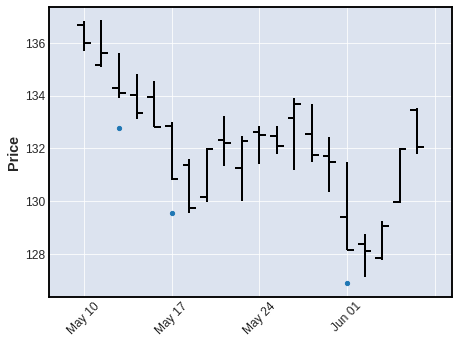

In [9]:
apd = mpf.make_addplot(signal,scatter=True)

mpf.plot(tdf,addplot=apd)

---

We can customize the marker size and shape, to make the scatter markers easier to see:

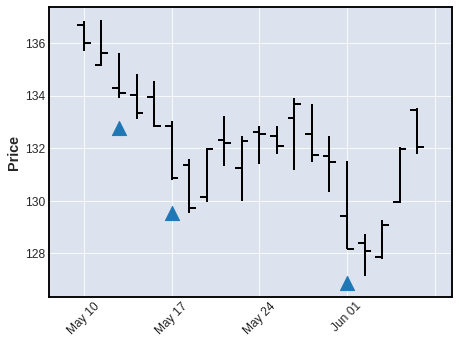

In [10]:
apd = mpf.make_addplot(signal,scatter=True,markersize=200,marker='^')

mpf.plot(tdf,addplot=apd)

---

## Plotting multiple additional data sets

There are two ways to plot multiple additional data sets.

- If the configuration is the same for all additional data sets, simply pass a `DataFrame` for the data.  All columns in the DataFrame will be plotted.

- Alternatively you can create multiple `dict`s and pass a `list` of `dict`s to the `addplot` keyword


---

Passing a DataFrame as the addplot data plots all columns in the DataFrame:

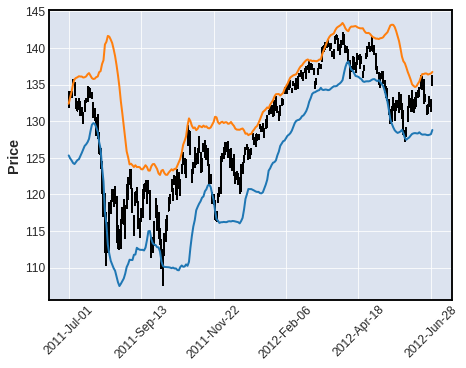

In [11]:
tcdf = df[['LowerB','UpperB']]  # DataFrame with two columns
apd  = mpf.make_addplot(tcdf)
mpf.plot(df,addplot=apd)

---

Setting `addplot=` a `list` of `dict`s is another to create multiple additional plots.<br>This method is necessary if the additional plots will have different configurations.  For example:

---

First prepare the data:

In [12]:
def percentB_aboveone(percentB,price):
    import numpy as np
    signal   = []
    previous = 2
    for date,value in percentB.iteritems():
        if value > 1 and previous <= 1:
            signal.append(price[date]*1.01)
        else:
            signal.append(np.nan)
        previous = value
    return signal

In [13]:
low_signal  = percentB_belowzero(df['PercentB'], df['Close']) 
high_signal = percentB_aboveone(df['PercentB'], df['Close'])

---

Now create the additional plot `dict`s and plot the data: 

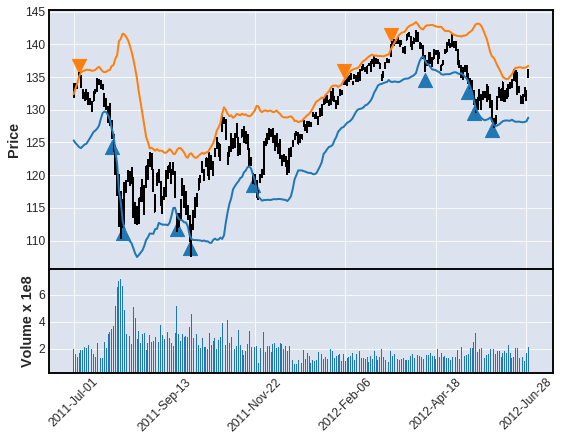

In [14]:
apds = [ mpf.make_addplot(tcdf),
         mpf.make_addplot(low_signal,scatter=True,markersize=200,marker='^'),
         mpf.make_addplot(high_signal,scatter=True,markersize=200,marker='v'),
       ]

mpf.plot(df,addplot=apds,figscale=1.25,volume=True)

---

## Plotting additional data on the lower panel

---
It is also possible to plot the additional data on the lower panel (where volume is usually plotted).
In this example, as is typical in Bollinger Band Analysis, we plot `PercentB` in the lower panel:

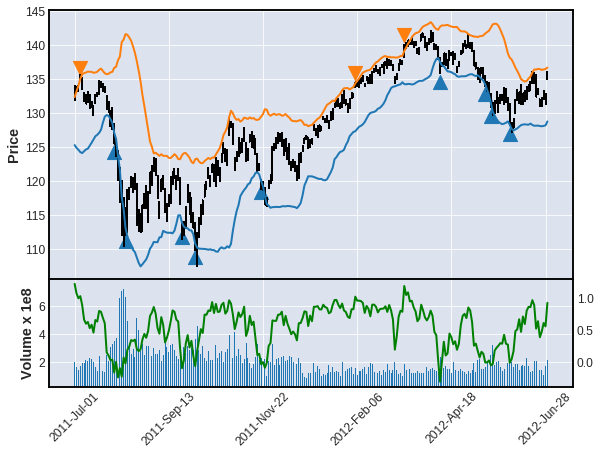

In [15]:
apds = [ mpf.make_addplot(tcdf),
         mpf.make_addplot(low_signal,scatter=True,markersize=200,marker='^'),
         mpf.make_addplot(high_signal,scatter=True,markersize=200,marker='v'),
         mpf.make_addplot((df['PercentB']),panel='lower',color='g')
       ]

mpf.plot(df,addplot=apds,figscale=1.3,volume=True)

---

## Plotting additional data with a *secondary y-axis*

---

- Notice in the above plot, in the lower panel with the "Volume" bars, we see the "Percent B" line has its own y-axis on the right side.


- `mpf.make_addplot()` has a keyword argument called `secondary_y` which can have **three** possible values: **`True`**, **`False`**, and **`'auto'`**.
  - The default value is `'auto'` which means if you don't specify `secondary_y`, or if you specify `secondary_y='auto'`, then `mpf.plot()` will attempt to decide whether a secondary y-axis is needed, by comparing the order of magnitude of the addplot data with the order of magnitude of the data that is already on the plot.
  - If **`mpf.plot()`** gets it wrong, you can always override by setting **`secondary_y=True`** or **`secondary_y=False`**.
  
---

- Below we see that `make_addplot()` also allows setting the `linestyle` for each additional plot.


- **Notice also** that we pass a alternative "mplfinance `style`" to demonstrate that **if the `style` specifies that the *primary y-axis* should be on the right, then `mpf.plot()` knows to put any `secondary_y` axes on the left.**

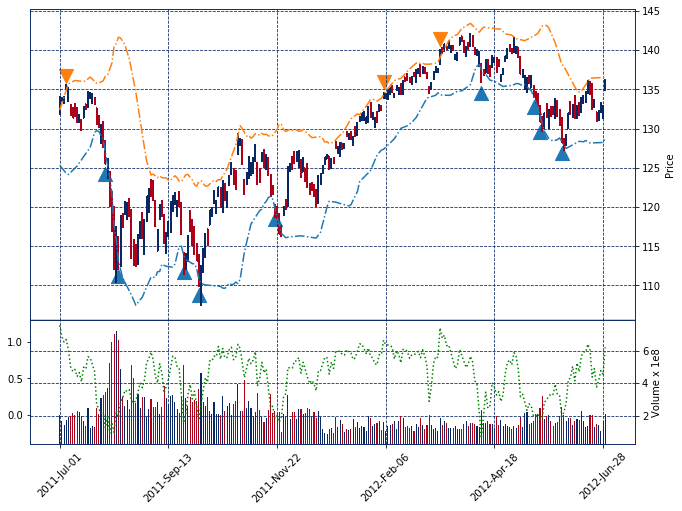

In [16]:
apds = [ mpf.make_addplot(tcdf,linestyle='dashdot'),
         mpf.make_addplot(low_signal,scatter=True,markersize=200,marker='^'),
         mpf.make_addplot(high_signal,scatter=True,markersize=200,marker='v'),
         mpf.make_addplot((df['PercentB']),panel='lower',color='g',linestyle='dotted')
       ]

mpf.plot(df,addplot=apds,figscale=1.5,volume=True,style='starsandstripes')

---
---

* **Below** we demonstrate that the main (upper) panel can also have a `secondary_y` axis:

In [17]:
import math
# change order of magnitude and range of low_signal, so that it will require a `secondary_y`
new_low_signal = [x*20.*math.sin(x) for x in low_signal] 

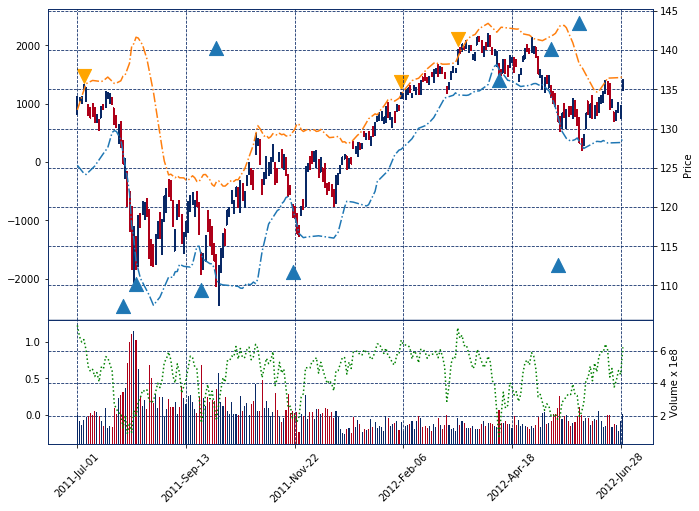

In [18]:
apds = [ mpf.make_addplot(tcdf,linestyle='dashdot'),
         mpf.make_addplot(new_low_signal,scatter=True,markersize=200,marker='^',secondary_y='auto'),
         mpf.make_addplot(high_signal,scatter=True,markersize=200,marker='v',color='orange'),
         mpf.make_addplot((df['PercentB']),panel='lower',color='g',linestyle='dotted')
       ]

mpf.plot(df,addplot=apds,figscale=1.5,volume=True,style='sas')

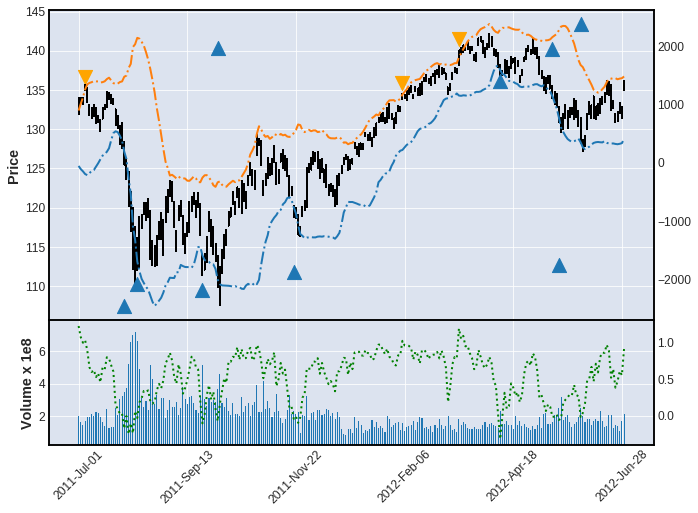

In [19]:
# The same plot, with a style that puts the primary y-axis on the left:
mpf.plot(df,addplot=apds,figscale=1.5,volume=True,style='default')